In [1]:
# Basic
import pandas as pd
import numpy as np

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# ML/DL
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, concatenate, Dense, Dropout
from keras.utils import plot_model

# IMDB
from keras.datasets import imdb

In [2]:
# 僅保留訓練資料集前10000個最常出現的單詞，捨棄低頻的單詞
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [3]:
# 看第一筆load進來的train_data的前十個字，已經做好text_to_sequence
display(train_data[0][0:10])
# 看第一筆train_labels的資料，0:負評,1:正評
display(train_labels[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

1

In [4]:
test_data

array([list([1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 5760, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 7944, 100, 28, 1668, 14, 31, 23, 27, 7479, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 7944, 451, 202, 14, 6, 717]),
       list([1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 2679, 23, 1310, 5, 109, 943, 4, 114, 9, 55, 606, 5, 111, 7, 4, 139, 193, 273, 23, 4, 172, 270, 11, 7216, 2, 4, 8463, 2801, 109, 1603, 21, 4, 22, 3861, 8, 6, 1193, 1330, 10, 10, 4, 105, 987, 35, 841, 2, 19, 861, 1074, 5, 1987, 2, 45, 55, 221, 15, 670, 5304, 526, 14, 1069, 4, 405, 5, 2438, 7, 27, 85, 108, 131, 4, 5045, 5304, 3884, 405, 9, 3523, 133, 5, 50, 13, 104, 51, 66, 166, 14, 22, 157, 9, 4, 530, 239, 34, 8463, 2801, 45, 407, 31, 7, 41, 3778, 105, 21, 59, 299, 12, 38, 950, 5, 4521, 15, 45, 629, 488, 2733, 127, 6, 52, 292, 17, 4, 6936, 185, 132, 1988, 5304, 1799, 488, 2693, 47, 6, 392, 173, 4, 2, 4378, 270, 2352, 4, 1500, 7, 

In [5]:
df = pd.DataFrame()
df['TRAIN_text_to_sequence'] = train_data
df['TEST_text_to_sequence'] = test_data
df

,TRAIN_text_to_sequence,TEST_text_to_sequence
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ...","[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5,..."
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,...","[1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 267..."
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5...","[1, 111, 748, 4368, 1133, 2, 2, 4, 87, 1551, 1..."
3,"[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153,...","[1, 13, 1228, 119, 14, 552, 7, 20, 190, 14, 58..."
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1...","[1, 40, 49, 85, 84, 1040, 146, 6, 783, 254, 43..."
...,...,...
24995,"[1, 14, 9, 6, 2758, 20, 21, 1517, 7, 2078, 5, ...","[1, 4, 274, 9, 128, 74, 4, 22, 669, 88, 7, 4, ..."
24996,"[1, 4679, 2784, 299, 6, 1042, 37, 80, 81, 233,...","[1, 4, 9212, 2293, 8, 126, 67, 6, 4210, 1494, ..."
24997,"[1, 11, 6, 230, 245, 6401, 9, 6, 1225, 446, 2,...","[1, 13, 1408, 15, 8, 135, 14, 9, 35, 32, 46, 3..."
24998,"[1, 1446, 7079, 69, 72, 3305, 13, 610, 930, 8,...","[1, 11, 119, 241, 9, 4, 840, 20, 12, 468, 15, ..."


In [6]:
# 下載IMDB的字典 word_index -> word:index
word_index = imdb.get_word_index()

# 鍵值對調 reverse_word_index -> index:word
reverse_word_index = {value:key for key,value in word_index.items()}

In [7]:
# 查看每一筆評論內容(index-3，因為index=0,1和2分別是“填充”,“序列開始”,“未知”的保留索引)
def read_IMDB_text(train_data):
  text = ' '.join([reverse_word_index.get(i-3,'START:') for i in train_data])
  return text

In [8]:
df['TRAIN_text'] = df['TRAIN_text_to_sequence'].apply(read_IMDB_text)
df['TEST_text'] = df['TEST_text_to_sequence'].apply(read_IMDB_text)
df.head()

,TRAIN_text_to_sequence,TEST_text_to_sequence,TRAIN_text,TEST_text
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ...","[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5,...",START: this film was just brilliant casting lo...,START: please give this one a miss br br START...
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,...","[1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 267...",START: big hair big boobs bad music and a gian...,START: this film requires a lot of patience be...
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5...","[1, 111, 748, 4368, 1133, 2, 2, 4, 87, 1551, 1...",START: this has to be one of the worst films o...,START: many animation buffs consider START: ST...
3,"[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153,...","[1, 13, 1228, 119, 14, 552, 7, 20, 190, 14, 58...",START: the START: START: at storytelling the t...,START: i generally love this type of movie how...
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1...","[1, 40, 49, 85, 84, 1040, 146, 6, 783, 254, 43...",START: worst mistake of my life br br i picked...,START: like some other people wrote i'm a die ...


In [9]:
# 觀察每一筆評論的長度
for seq in df['TRAIN_text_to_sequence'][:5]:
  print(len(seq), seq[:5], ' ...')

218 [1, 14, 22, 16, 43]  ...
189 [1, 194, 1153, 194, 8255]  ...
141 [1, 14, 47, 8, 30]  ...
550 [1, 4, 2, 2, 33]  ...
147 [1, 249, 1323, 7, 61]  ...


In [10]:
# 最長評論的長度
max_seq_len = max([len(seq) for seq in df['TRAIN_text_to_sequence']])
max_seq_len

2494

In [11]:
# 評論長度的平均值
max_seq_len = np.mean([len(seq) for seq in df['TRAIN_text_to_sequence']])
max_seq_len

238.71364

In [12]:
# 序列的 Zero Padding
MAX_SEQUENCE_LENGTH = 240
X_train = keras.preprocessing.sequence.pad_sequences(train_data,maxlen=MAX_SEQUENCE_LENGTH)
Y_train = keras.utils.to_categorical(train_labels)

display(X_train)
display(Y_train)

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [13]:
display(X_train.shape)
display(Y_train.shape)

(25000, 240)

(25000, 2)

In [14]:
VALIDATION_RATIO = 0.2

RANDOM_STATE = 914

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(20000, 240)
(5000, 240)
(20000, 2)
(5000, 2)


In [32]:
# 基本參數設置，有幾個分類
NUM_CLASSES = 2

# 在語料庫裡有多少詞彙
MAX_NUM_WORDS = 40000

# 一個詞向量的維度
NUM_EMBEDDING_DIM = 256

# Dense層輸出的向量維度
NUM_DENSE_UNITS = 256

# LSTM 輸出的向量維度
NUM_LSTM_UNITS = 128

# 決定一次要放多少成對標題給模型訓練
BATCH_SIZE = 512

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 20

In [16]:
# # 建立 LSTM 架構
# from keras import Input
# from keras.layers import Embedding, LSTM, concatenate, Dense, Dropout
# from keras.models import Model

# # 定義模型輸入，評論是一個長度為 200 的數字序列
# data_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')

# # word embedding，把文字轉成一個詞向量的序列，而每個詞向量的維度為256
# embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
# data_embedded = embedding_layer(data_input)



# # LSTM層，評論經過此層後為一個 128 維度向量
# lstm = LSTM(NUM_LSTM_UNITS)
# data_output = lstm(data_embedded)

# # dense層 + sigmoid活化函式，可以回傳 2 個分類，屬於各類別的可能機率
# dense =  Dense(units=NUM_CLASSES, activation='sigmoid')
# predictions = dense(data_output)

# # 彙整模型
# model = Model(inputs=[data_input], outputs=predictions)

In [33]:
model = Sequential()                   # 線性model
model.add(Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))  # word embedding
model.add(Dropout(0.2))                  # 訓練期間drop掉20%神經元
model.add(LSTM(NUM_LSTM_UNITS))              # LSTM層輸出128個神經元
model.add(Dense(units=NUM_DENSE_UNITS, activation='relu')) # 隱藏層有256個神經元
model.add(Dense(units=NUM_CLASSES, activation='sigmoid')) # 輸出層的活化函式為sigmoid

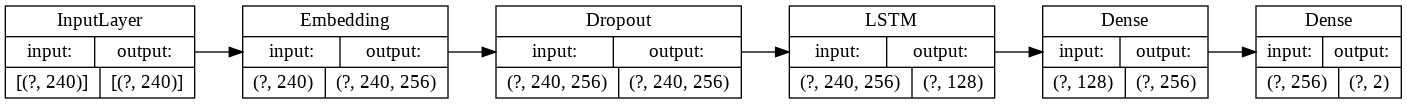

In [34]:
plot_model(
  model, 
  # to_file='model.png', 
  show_shapes=True, 
  show_layer_names=False, 
  rankdir='LR')

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 240, 256)          10240000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 240, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 10,470,658
Trainable params: 10,470,658
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'])

In [37]:
# 實際訓練模型
history = model.fit(
  # 輸入是兩個長度為 MAX_SEQUENCE_LENGTH 的數字序列
  x = x_train, 
  y = y_train,
  batch_size = BATCH_SIZE,
  epochs = NUM_EPOCHS,
  # 每個 epoch 完後計算驗證資料集
  # 上的 Loss 以及準確度
  validation_data=(
      x_val, 
      y_val
  ),
  # 每個 epoch 隨機調整訓練資料集
  # 裡頭的數據以讓訓練過程更穩定
  shuffle=True
)

Epoch 1/20
40/40 [==============================] - 9s 225ms/step - loss: 0.6202 - accuracy: 0.6640 - val_loss: 0.4395 - val_accuracy: 0.7952
Epoch 2/20
40/40 [==============================] - 9s 214ms/step - loss: 0.3179 - accuracy: 0.8654 - val_loss: 0.3278 - val_accuracy: 0.8644
Epoch 3/20
40/40 [==============================] - 9s 213ms/step - loss: 0.2041 - accuracy: 0.9237 - val_loss: 0.3572 - val_accuracy: 0.8676
Epoch 4/20
40/40 [==============================] - 9s 217ms/step - loss: 0.1587 - accuracy: 0.9430 - val_loss: 0.3456 - val_accuracy: 0.8728
Epoch 5/20
40/40 [==============================] - 9s 214ms/step - loss: 0.1059 - accuracy: 0.9651 - val_loss: 0.3739 - val_accuracy: 0.8706
Epoch 6/20
40/40 [==============================] - 9s 214ms/step - loss: 0.0776 - accuracy: 0.9754 - val_loss: 0.4242 - val_accuracy: 0.8662
Epoch 7/20
40/40 [==============================] - 9s 216ms/step - loss: 0.0739 - accuracy: 0.9739 - val_loss: 0.4609 - val_accuracy: 0.8648
Epoch 

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

In [39]:
def plot_fig(epochs,train,val,train_label,val_label,type):
  plt.plot(epochs, train, 'bo', label=train_label)
  plt.plot(epochs, val, 'b', label=val_label)
  plt.title('Training and validation '+type)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

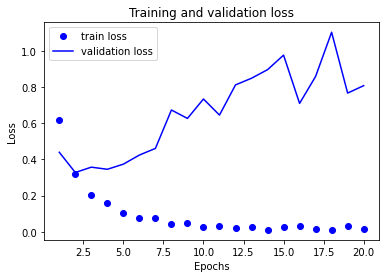

In [40]:
plot_fig(epochs,loss,val_loss,'train loss','validation loss','loss')

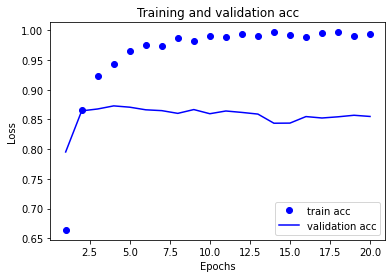

In [41]:
plot_fig(epochs,acc,val_acc,'train acc','validation acc','acc')

In [42]:
x_test = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=MAX_SEQUENCE_LENGTH)  

In [43]:
# 利用已訓練的模型做預測
predictions = model.predict([x_test])

In [44]:
df['IMDB_label_ans'] = test_labels
df['test_predict'] = np.argmax(predictions, axis=1)
df

,TRAIN_text_to_sequence,TEST_text_to_sequence,TRAIN_text,TEST_text,IMDB_label_ans,test_predict
0,"[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, ...","[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5,...",START: this film was just brilliant casting lo...,START: please give this one a miss br br START...,0,0
1,"[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463,...","[1, 14, 22, 3443, 6, 176, 7, 5063, 88, 12, 267...",START: big hair big boobs bad music and a gian...,START: this film requires a lot of patience be...,1,1
2,"[1, 14, 47, 8, 30, 31, 7, 4, 249, 108, 7, 4, 5...","[1, 111, 748, 4368, 1133, 2, 2, 4, 87, 1551, 1...",START: this has to be one of the worst films o...,START: many animation buffs consider START: ST...,1,0
3,"[1, 4, 2, 2, 33, 2804, 4, 2040, 432, 111, 153,...","[1, 13, 1228, 119, 14, 552, 7, 20, 190, 14, 58...",START: the START: START: at storytelling the t...,START: i generally love this type of movie how...,0,1
4,"[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 1...","[1, 40, 49, 85, 84, 1040, 146, 6, 783, 254, 43...",START: worst mistake of my life br br i picked...,START: like some other people wrote i'm a die ...,1,1
...,...,...,...,...,...,...
24995,"[1, 14, 9, 6, 2758, 20, 21, 1517, 7, 2078, 5, ...","[1, 4, 274, 9, 128, 74, 4, 22, 669, 88, 7, 4, ...",START: this is a racist movie but worthy of st...,START: the book is better than the film mostly...,1,1
24996,"[1, 4679, 2784, 299, 6, 1042, 37, 80, 81, 233,...","[1, 4, 9212, 2293, 8, 126, 67, 6, 4210, 1494, ...",START: bela lugosi plays a doctor who will do ...,START: the largest crowd to ever see a wrestli...,1,1
24997,"[1, 11, 6, 230, 245, 6401, 9, 6, 1225, 446, 2,...","[1, 13, 1408, 15, 8, 135, 14, 9, 35, 32, 46, 3...",START: in a far away galaxy is a planet called...,START: i suppose that to say this is an all ou...,0,0
24998,"[1, 1446, 7079, 69, 72, 3305, 13, 610, 930, 8,...","[1, 11, 119, 241, 9, 4, 840, 20, 12, 468, 15, ...",START: six degrees had me hooked i looked forw...,START: in love 2 is the third movie it seemed ...,0,0


In [45]:
pred_acc = df[df['IMDB_label_ans']==df['test_predict']].count()[0]/df.shape[0]
pred_acc

0.84208